# 12速ドライブトレイン駆動効率試験

自転車クランク部および駆動輪で計測したパワーを元に、12速および11速ドライブトレインの各ギヤの組み合わせで発生する駆動抵抗を推定する統計モデルを作成した。

## 方法

クランクのパワーメーターの計測値をドライブトレインへの入力、スマートトレーナーの計測値を出力とし、計測したサンプルを元に線形回帰により駆動抵抗の統計モデルを作成する。
クランクにStages Powerパワーメーター(CP)を取り付け、ドライブトレインを介してWahoo Kickr 2018(DP)を駆動する。ドライブトレインはShimano FC-R9200(54-40T)と同CS-R9200(11-34T)を使用する。
22通りのギヤの組み合わせをランダム化し、各ギヤの組み合わせで200ワット90rpmでCPを駆動できるようDPの負荷を調整したのちに2分間の定常走行時のパワーを計測する。ドライブトレインを駆動する被験者(筆者)の体力水準で22x2分の定常走行を維持できるできるだけ高いパワーである200ワットを設定した。
計測に先だち15分間のウォーミングアップの後、CPとDPのキャリブレーションを行った。

計測後、ドライブトレインの駆動抵抗を構成する要素から単位時間あたりのチェーンの屈曲量 $\mathrm{Bending}$、前後スプロケットのオフセットによるチェーンの角度 $\mathrm{Offset}$、チェーン上弦にかかる張力 $\mathrm{Tension}$と、それぞれの交互作用をモデルの説明変数として選択し、線形回帰によりモデルの各因子のパラメータ $\beta$ を求める。

$$
\begin{align}
\mathrm{Friction} = \beta_{0} + \beta_{1}\mathrm{Bending} + \beta_{2}\mathrm{Offset} + \beta_{3}\mathrm{Tension} + \beta_{4}\mathrm{Bending} \cdot \mathrm{Tension} + \beta_{5}\mathrm{Offset} \cdot \mathrm{Tension} + \beta_{6}\mathrm{Bending} \cdot \mathrm{Offset} + \epsilon
\end{align}
$$


In [1]:
!pip install eli5

import math

import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from scipy import stats
import seaborn as sb
from sklearn import linear_model
import pandas as pd

## 結果


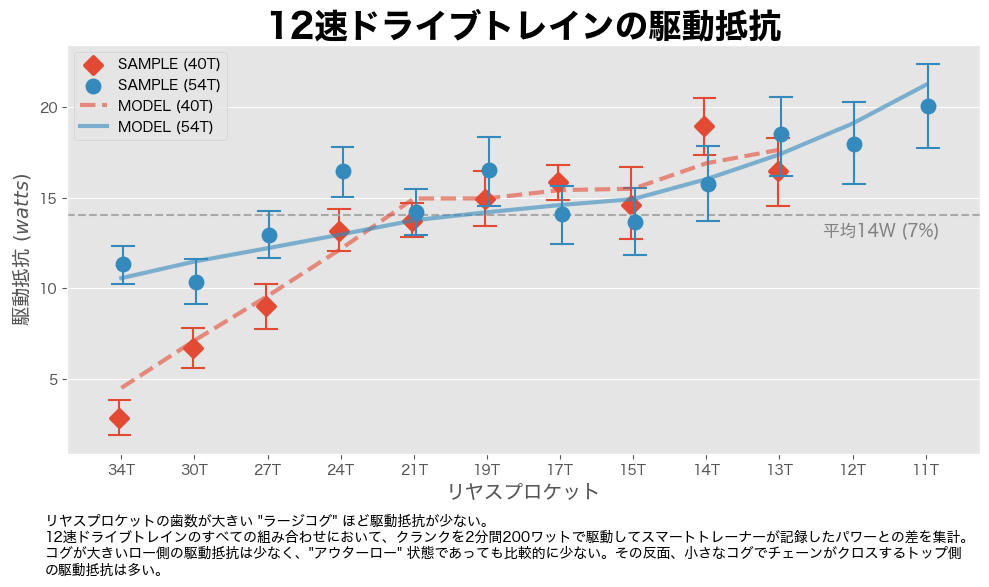

In [2]:
results = pd.read_csv(f'data/2minAt200W-54-40.csv')
wheel = results[results.location=='wheel']
crank = results[results.location=='crank']
mean = wheel.power.mean()
wheel = wheel.assign(friction=crank.power.mean() - wheel.power)
input_power = crank.power.mean()

chain_pitch = 0.01275
chainstay_length = 0.410
drivetrain_12speed = {
    'cog': {1: 34, 2: 30, 3: 27, 4: 24, 5: 21, 6: 19, 7: 17, 8: 15, 9: 14, 10: 13, 11: 12, 12: 11},
    'inner': {1: 4, 2: 3, 3: 2, 4: 1, 5: 0, 6: 1, 7: 2, 8: 4, 9: 4, 10: 5, 11: 6, 12: 7},
    'outer': {1: 7, 2: 6, 3: 5, 4: 4, 5: 3, 6: 2, 7: 1, 8: 0, 9: 1, 10 :2, 11: 3, 12: 4},
    'side_pitch': 0.0035,
}


def update_chain_offset(df, drivetrain):
    # Determine the horizontal chain angle from the cog offset and chainstay length
    df.loc[df.front < 50, 'offset'] = df[df.front < 50].rear.apply(
        lambda x: np.arctan(drivetrain['inner'][x] * drivetrain['side_pitch'] / chainstay_length))
    df.loc[df.front >= 50, 'offset'] = df[df.front >= 50].rear.apply(
        lambda x: np.arctan(drivetrain['outer'][x] * drivetrain['side_pitch'] / chainstay_length))    
    return df


def update_drivetrain_params(df):
    df['gear_ratio'] = df.front / df.rear_cog
    df['rotation_rear'] = df['cadence'] * df['gear_ratio']

    df['tension'] = ((input_power / (df['cadence'] * (2 * math.pi) / 60))  # torque
                     / (chain_pitch / (2 * np.sin(math.pi / df['front']))))  # lever length
    df['bending'] = ((2*math.pi / df['front']) * (df['front'] * df['cadence'] / 60)
                     + (2*math.pi / df['rear_cog']) * (df['rear_cog'] * df['rotation_rear'] / 60))
    # interactions
    df['bending_x_tension'] = df['bending'] * df['tension']
    df['bending_x_offset'] = df['bending'] * df['offset']
    df['tension_x_offset'] = df['tension'] * df['offset']
    return df


wheel['rear_cog'] = wheel.rear.apply(lambda x: drivetrain_12speed['cog'][x])
wheel = update_chain_offset(wheel, drivetrain=drivetrain_12speed)
wheel = update_drivetrain_params(wheel)
model = linear_model.LinearRegression()
model_factors = ['bending', 'offset', 'tension', 'bending_x_tension', 'bending_x_offset', 'tension_x_offset']
X = wheel[model_factors]
Y = wheel['friction']
model.fit(X.values, Y.values)

predict12 = pd.DataFrame({'rear': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                          'front': [40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
                                    54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54]})
predict12['cadence'] = 90
predict12['power'] = 200
predict12['rear_cog'] = predict12.rear.apply(lambda x: drivetrain_12speed['cog'][x])
predict12 = update_chain_offset(predict12, drivetrain=drivetrain_12speed)
predict12 = update_drivetrain_params(predict12)
predict12["predict"] = model.predict(predict12[model_factors].values)


plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['Hiragino Sans']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100)
ax.axhline(crank.power.mean() - wheel.power.mean(), color='darkgray', linestyle='--')
ax.annotate(f'平均{crank.power.mean() - wheel.power.mean():.0f}W ({100*(crank.power.mean()-wheel.power.mean())/200:.0f}%)',
            xy=(9.6, crank.power.mean() - wheel.power.mean() -1.2),
            color='gray',
            fontsize=12)
sb.pointplot(data=wheel,
             x="rear", y="friction", hue="front",
             capsize=0.3,
             dodge=True,
             markers=['D', 'o'],
             linestyles=['', ''],
             errwidth=1.5,
             scale=1.3,
             ax=ax)

predict12['rear_index'] = predict12['rear'] - 1  #FIXME
ax.plot('rear_index', 'predict',
        data=predict12[predict12.front==40],
        linewidth=3.0,
        linestyle='--',
        alpha=0.6,
        label='12速 40T')
ax.plot('rear_index', 'predict',
        data=predict12[predict12.front==54],
        linewidth=3.0,
        alpha=0.6,
        label='12速 54T')

plt.title('12速ドライブトレインの駆動抵抗', fontsize=24, fontweight='bold')
plt.suptitle(('リヤスプロケットの歯数が大きい "ラージコグ" ほど駆動抵抗が少ない。\n'
              '12速ドライブトレインのすべての組み合わせにおいて、クランクを2分間200ワットで駆動してスマートトレーナーが記録したパワーとの差を集計。\n'
              'コグが大きいロー側の駆動抵抗は少なく、"アウターロー" 状態であっても比較的に少ない。その反面、小さなコグでチェーンがクロスするトップ側\nの駆動抵抗は多い。'),
             ha='left',
             va='bottom',
             x=0.05, y=-0.10,
             fontsize=10,
             fontweight='normal')
ax.set_ylabel(r'駆動抵抗 $(watts)$', fontsize=14)
ax.set_xlabel('リヤスプロケット', fontsize=14)
ax.set_xticks(range(0, 12),
              labels=['34T', '30T', '27T', '24T', '21T', '19T', '17T', '15T', '14T', '13T', '12T', '11T'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['SAMPLE (40T)', 'SAMPLE (54T)', 'MODEL (40T)', 'MODEL (54T)'], title=None)
fig.tight_layout()

統計モデルの各パラメータを Table.1 に示す。

In [3]:
def get_conf_int(alpha, lr, X, y):    
    coefs = np.r_[[lr.intercept_], lr.coef_]
    X_aux = X.copy()
    X_aux.insert(0, '(intercept)', 1)
    dof = -np.diff(X_aux.shape)[0]
    mse = np.sum((y - lr.predict(X.values)) ** 2) / dof
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    t_val = stats.t.isf(alpha/2, dof)
    gap = t_val * np.sqrt(mse * var_params)

    return pd.DataFrame({
        'mean': np.append([lr.intercept_], lr.coef_),
        'lower': coefs - gap, 'upper': coefs + gap
    }, index=X_aux.columns)

# Table.1
get_conf_int(1-0.95, model, X, Y)

,mean,lower,upper
(intercept),33.723266,17.469281,49.977251
bending,-1.110549,-1.479248,-0.741850
offset,306.237204,25.682553,586.791856
tension,-0.138781,-0.199273,-0.078290
bending_x_tension,0.006694,0.005097,0.008291
bending_x_offset,4.180412,0.235987,8.124837
tension_x_offset,-2.177902,-3.060581,-1.295223


各パラメータの推定量への寄与度を Table.2 に示す。

In [4]:
perm = PermutationImportance(model, random_state=1).fit(X.values, Y.values)
# Table.2
eli5.explain_weights_df(perm, feature_names=X.columns.tolist())

,feature,weight,std
0,bending_x_tension,1.943980,0.029681
1,bending,1.705847,0.038555
2,tension_x_offset,0.758830,0.014412
3,offset,0.332790,0.012174
4,tension,0.326613,0.003459
5,bending_x_offset,0.073231,0.006132


### 統計モデルを用いた12および11速の比較

作成した統計モデルを応用して、同程度のギヤ比を備えた11速構成の駆動抵抗を推定する。

|groupset               |front   |rear    |
|-----------------------|--------|--------|
|Dura-Ace R9200 12speed | 54-40T | 11-34T |
|Dura-Ace R9100 11speed | 52-36T | 11-28T | 

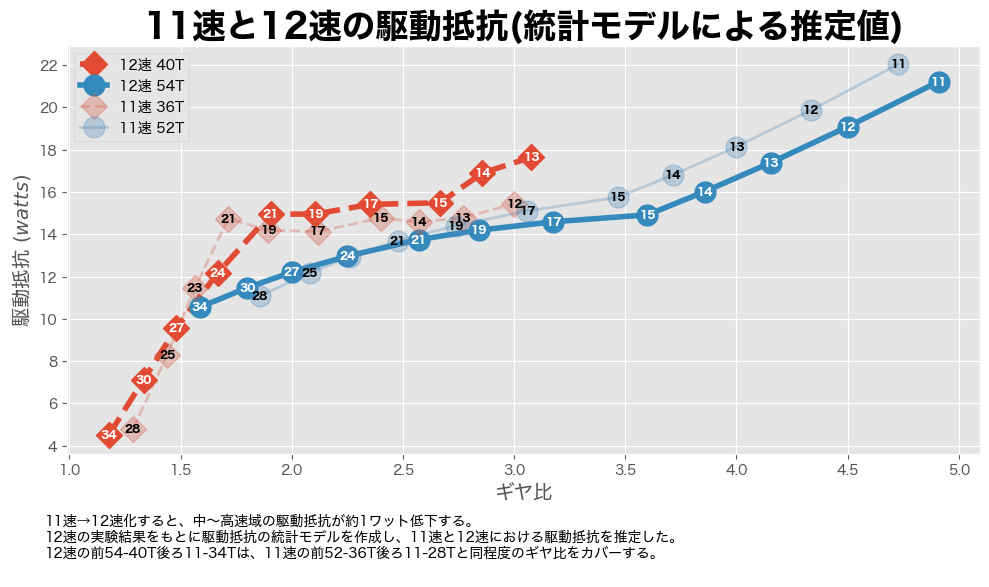

In [5]:
drivetrain_11speed = {
    'cog': {1: 28, 2: 25, 3: 23, 4: 21, 5: 19, 6: 17, 7: 15, 8: 14, 9: 13, 10: 12, 11: 11},
    'outer': {1: 6, 2: 5, 3: 4, 4: 3, 5: 2, 6: 1, 7: 0, 8: 1, 9: 2, 10: 3, 11: 4},
    'inner': {1: 3, 2: 2, 3: 1, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5, 10: 6, 11: 7},
    'side_pitch': 0.00381,
}
predict11 = pd.DataFrame({'rear': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                          'front': [36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
                                    52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]})
predict11['cadence'] = 90
predict11['power'] = 200
predict11['rear_cog'] = predict11.rear.apply(lambda x: drivetrain_11speed['cog'][x])
predict11 = update_chain_offset(predict11, drivetrain=drivetrain_11speed)
predict11 = update_drivetrain_params(predict11)
predict11["predict"] = model.predict(predict11[model_factors].values)


plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['Hiragino Sans']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=100)

ax.plot('gear_ratio', 'predict',
        data=predict12[predict12.front==40],
        linewidth=4.0,
        linestyle='--',
        alpha=1.0,
        marker='D',
        markersize=13,
        label='12速 40T')
ax.plot('gear_ratio', 'predict',
        data=predict12[predict12.front==54],
        linewidth=4.0,
        alpha=1.0,
        marker='o',
        markersize=15,
        label='12速 54T')
ax.plot('gear_ratio', 'predict',
        data=predict11[predict11.front==36],
        linewidth=2.0,
        linestyle='--',
        alpha=0.3,
        color='#D1553E',
        marker='D',
        markersize=13,
        label='11速 36T')
ax.plot('gear_ratio', 'predict',
        data=predict11[predict11.front==52],
        linewidth=2.0,
        linestyle='-',
        color='#4D88B8',
        alpha=0.3,
        marker='o',
        markersize=15,      
        label='11速 52T')
for i, row in predict11.iterrows():
    if row.front == 36 and row.rear_cog in (28, 25, 23, 21, 19, 17, 15, 14, 13, 12):
        ax.annotate(f'{row.rear_cog:.0f}',
                    (row.gear_ratio, row.predict),
                    ha='center', va='center',
                    fontsize=8,
                    fontweight='bold',
                    color='black')
    if row.front == 52 and row.rear_cog in (28, 25, 21, 19, 17, 15, 14, 13, 12, 11):
        ax.annotate(f'{row.rear_cog:.0f}',
                    (row.gear_ratio, row.predict),
                    ha='center', va='center',
                    fontsize=8,
                    fontweight='bold',
                    color='black')

for i, row in predict12.iterrows():
    ax.annotate(f'{row.rear_cog:.0f}',
                (row.gear_ratio, row.predict),
                ha='center', va='center',
                fontsize=8,
                fontweight='bold',
                color='white')
        
loc = plticker.MultipleLocator(base=2.0)
ax.yaxis.set_major_locator(loc)
ax.legend()
plt.title('11速と12速の駆動抵抗(統計モデルによる推定値)', fontsize=24, fontweight='bold')
plt.suptitle(('11速→12速化すると、中〜高速域の駆動抵抗が約1ワット低下する。\n'
              '12速の実験結果をもとに駆動抵抗の統計モデルを作成し、11速と12速における駆動抵抗を推定した。\n'  
              '12速の前54-40T後ろ11-34Tは、11速の前52-36T後ろ11-28Tと同程度のギヤ比をカバーする。\n'
             ),
             ha='left',
             va='bottom',
             x=0.05, y=-0.10,
             fontsize=10,
             fontweight='normal')
ax.set_ylabel(r'駆動抵抗 $(watts)$', fontsize=14)
ax.set_xlabel('ギヤ比', fontsize=14)
fig.tight_layout()

フロントチェーンリングを大径化してドライブトレイン全体のコグを大型化すると、$\mathrm{Bending}$ が減少して中高速域での駆動抵抗が低下することが推察される。
統計モデルの分析により、$\mathrm{Bending}$ や、$\mathrm{Tension}$ 、$\mathrm{Offset}$ といった単一の因子作用よりも、$\mathrm{Bending} \cdot \mathrm{Tension} $ をはじめとした交互作用の寄与度が比較的大きいため、駆動抵抗の動態は複雑であることがわかった。

シマノDi2の前後ギヤ自動変速機能のシンクロシフトの出荷時設定は、このモデルに照らし合わせても妥当であると推察される。

## Appendix 実験データのファイル形式

実験結果は縦持ちのCSVファイル。後ろギヤは歯数ではなく変速位置(ロー:1 トップ:12)であることに注意。

In [6]:
pd.read_csv(f'data/2minAt200W-54-40.csv')

,timestamp,location,serial,power,cadence,front,rear
0,2023-04-28T18:17:30.252957,wheel,19005,179.0,88.0,40,5
1,2023-04-28T18:17:31.186085,crank,52853,198.9,92.0,40,5
2,2023-04-28T18:17:31.685463,crank,52853,209.6,93.1,40,5
3,2023-04-28T18:17:31.751008,wheel,19005,188.0,90.0,40,5
4,2023-04-28T18:17:32.250392,wheel,19005,171.8,89.0,40,5
...,...,...,...,...,...,...,...
8099,2023-04-28T20:15:15.635952,crank,52853,202.0,94.7,54,10
8100,2023-04-28T20:15:16.135479,crank,52853,210.7,93.2,54,10
8101,2023-04-28T20:15:16.620027,wheel,19005,196.0,95.0,54,10
8102,2023-04-28T20:15:17.119416,wheel,19005,193.0,95.0,54,10
